<b>Coding to Julia 1.0.5</b>

微粒子 Brownian motion の系を考える.
このとき,

* 微粒子の質量 $m$
* 微粒子に及ぼされる粘性抵抗力の係数 $\gamma$
* 標準正規分布に従う乱数で与えられるランダム力 $\eta(t)$ 

とする.

また,

* 初期位置 $x_0$
* 初速度 $v_0$
* 時間ステップ $N$
* Brownian motion のサンプル数 $M$
* 時間刻み幅 $\Delta t$

としておく,

In [ ]:
using Distributions


#conditions
m = 1.0 #mass
γ = 1.0 #resistance coefficient

x₀ = 0.0 #initial position
v₀ = 0.0 #initial velocity

N = 500 #time step
M = 10000 #number of samples
tₘᵢₙ = 0.0
tₘₐₓ = 30.0
Δt = (tₘₐₓ - tₘᵢₙ)/N #time step width

kT = 1.0 #k:Boltzmann constant, T:temperature
σ = sqrt(2*γ*kT/Δt)

function Random()
    η = rand(Normal(0, σ), 1)[end] #random force
    return η
end 

η = Random()

Brownian motionを記述する運動方程式としては, Langevin方程式がある．

いま,一次元で粒子の運動を考え,時刻 $t$ における粒子の位置を $x(t)$ とすると,一次元Langevin方程式は

$$ m\frac{d^2x}{dt^2}(t) = -\gamma\frac{dx}{dt}(t) + \eta(t) $$

のような形で与えられる．

ここで右辺第一項は,粘性抵抗力で,速度に比例して逆向きに作用する．

In [73]:
#Langevin equation discretization
function Langevin(xᵢ,vᵢ,η)
    vᵢ₊₁ = vᵢ - ((γ*vᵢ - η)/m) * Δt
    xᵢ₊₁ = xᵢ + vᵢ*Δt
    vᵢ = vᵢ₊₁
    xᵢ = xᵢ₊₁
    return xᵢ, vᵢ
end

Langevin(x₀,v₀,η)

(0.0, -0.10706259054363204)

ここで,時刻 $t = 0$ のときの位置を $x(0)$ , 時刻 $t = t'$ のときの位置を $x(t')$ とすると,その変位 $x(t')-x(0)$ は**末端間距離** $R$ に対応する.

このとき, 任意時間 $t$ におけるBrownian motion の抽出サンプル数 $N$ に対する平均二乗末端間距離 $<R^2>$ は次式で与えられる.

$$ <R^2> = \frac{1}{N}\sum^N_{i=1}(x(t')-x(0))^2 $$


In [78]:
ΣR²_list = zeros(N+1) #sum of squared of R
R²ₐᵥₑ_list = [] # list of mean-square value <R²>
xᵢ⁽ʲ⁾_list = [] # list of displacement x (xᵢ⁽ʲ⁾ is i-by-j matrix)
xᵢ⁽ʲ⁾²_list = []

for j in 1:M  # j is iteration of samples
    #variable initialization
    R²_list = zeros()
    x_list = [x₀]
    x²_list = [x₀^2]
    x,v = x₀, v₀
    for i in 1:N  # i is time step of samples
        η = Random() #random force
        x,v = Langevin(x,v,η)
        x_list = hcat(x_list,[x]) # hcat is that function Adding elements
        x²_list = hcat(x²_list,[x^2])
        R²_list = hcat(R²_list, [(x-x₀)^2]) # end-to-end distance R = x - x₀
    end
    xᵢ⁽ʲ⁾_list = vcat(xᵢ⁽ʲ⁾_list,[x_list'])
    xᵢ⁽ʲ⁾²_list = vcat(xᵢ⁽ʲ⁾²_list,[x²_list'])
    ΣR²_list += vec(R²_list)
end

R²ₐᵥₑ_list = ΣR²_list/M

501-element Array{Float64,1}:
  0.0                  
  0.0                  
  0.0004363974351204815
  0.00208280059112543  
  0.005599973744730385 
  0.011441226599585262 
  0.020035679641424626 
  0.03158082413035896  
  0.046364615952400275 
  0.06449481607268583  
  0.08606946147844054  
  0.1113153309024246   
  0.14027268113304578  
  ⋮                    
 56.81995972079467     
 56.951821750395       
 57.08355534066592     
 57.21211298688448     
 57.34152468448814     
 57.47023524787651     
 57.60143210155035     
 57.73095025094749     
 57.85837134252566     
 57.98692242450554     
 58.118566315366515    
 58.25100787760844     

In [ ]:
using Plots
gr()
plot(
    plot([tₘᵢₙ:Δt:tₘₐₓ], xᵢ⁽ʲ⁾_list[20:30], marker = :auto, legend = :none, xlabel="time t", ylabel="displacement x"),
    size = (950,900)
    )

1905年に Einstein は“Investigation on the Theory of the Brownian Movement”の論文において,微粒子の二乗平均変位 $<x^2>$ が時間 $t$ に比例することを導いた.

これより,統計的に計算した平均二乗末端間距離 $<R^2>$ も時間 $t$ に対し,線形関係が得られると考えられる.

grad(<R²>) = 2.0150227579876727

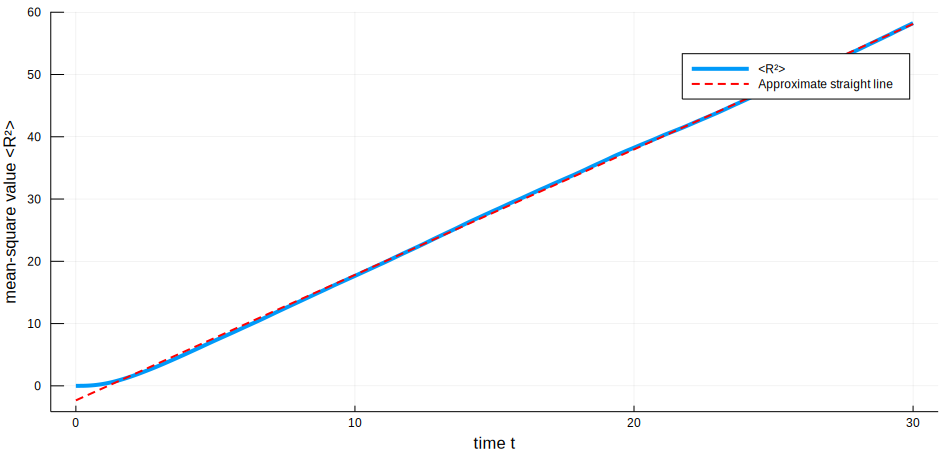

In [79]:
using Plots
gr()

t_list = [tₘᵢₙ]
for i in 1:N  # i is time step of samples
    t_list = hcat(t_list, [i*Δt]) 
end

vec(t_list)
a = cov(t_list',R²ₐᵥₑ_list)[end] / std(t_list')^2
b = mean(R²ₐᵥₑ_list)-a*mean(t_list)
b_list = [b]

for i in 1:N  # i is time step of samples
    b_list = hcat(b_list, [b]) 
end
y = vec(a*t_list+b_list)

print("grad(<R²>) = ",a[end])

plot(t_list', R²ₐᵥₑ_list, linewidth=4, label="<R²>", xlabel="time t", ylabel="mean-square value <R²>",size=(950,450))
plot!(t_list', y, color=:red, linewidth=2, linestyle=:dash, label="Approximate straight line", xlabel="time t", ylabel="mean-square value <R²>",size=(950,450))